In [1]:
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary
from torch import optim
from torch.utils.data import TensorDataset
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms.v2 import Compose, ToDtype, Normalize, RandomAutocontrast, Resize, PILToTensor
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2
from collections import defaultdict
import random
import csv

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
class Data():
    def __init__(self, image_dir, train, transform):
        """
        image_dir: путь к папке с изображениями
        transform: torchvision трансформации
        """
        self.image_dir = image_dir
        self.transform = transform
        self.train = train

        # Список всех файлов с нужными расширениями
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.endswith('.jpg')
        ]

        if self.train:
            train_ans = pd.read_csv('human_poses_data/train_answers.csv')
            label_map = dict(zip(train_ans['img_id'].values, train_ans['target_feature'].values))
            self.label_map = label_map
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Загружаем изображение
        image = Image.open(img_path)
        image = self.transform(image)
            
        # Определяем метку по имени файла
        if self.train:
            label = self.label_map[int(img_name.split('.')[0])]
            return image, label
        else:
            return image

In [4]:
transform = Compose([
    Resize((64, 64)),
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
#    RandomAutocontrast(p=1.0),
])

train_data = Data(image_dir="human_poses_data/img_train",
                 train=True,
                 transform=transform)

test_set = Data(image_dir="human_poses_data/img_test",
                 train=False,
                 transform=transform)

train_set, valid_set = random_split(train_data, (0.8, 0.2))


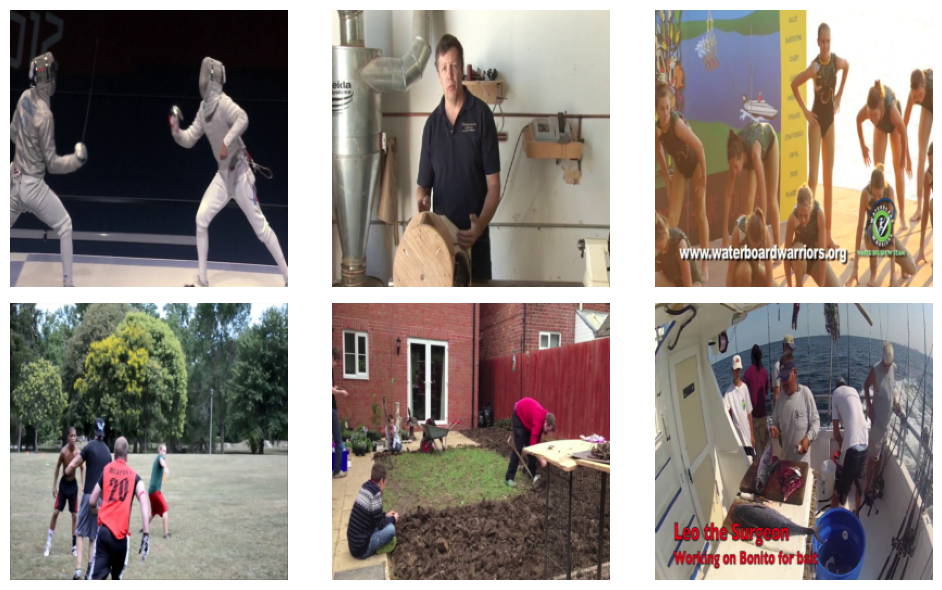

In [28]:
def show_dataset_images(dataset, num_images=6, cols=3):
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(10, 6))
    
    for i in range(num_images):
        image, _ = dataset[i]
        
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        image = image * 0.25 + 0.5
        image = np.clip(image, 0, 1)
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_dataset_images(train_set, num_images=6)

In [5]:
class BalancedDataset(Dataset):
    def __init__(self, original_dataset, target_size=1000):
        self.original_dataset = original_dataset
        self.target_size = target_size
        
        self.class_indices = defaultdict(list)
        for i in range(len(original_dataset)):
            _, label = original_dataset[i]
            self.class_indices[label].append(i)
        
        self.samples = []
        
        for class_id, indices in self.class_indices.items():
            current_count = len(indices)
            
            if current_count == 0:
                continue
                
            elif current_count < target_size:
                needed = target_size - current_count
                
                self.samples.extend([(idx, False) for idx in indices])
                
                aug_source_indices = np.random.choice(indices, size=needed, replace=True)
                self.samples.extend([(idx, True) for idx in aug_source_indices])
                
            elif current_count > target_size:
                selected_indices = random.sample(indices, target_size)
                self.samples.extend([(idx, False) for idx in selected_indices])
                
        self.aug_transform = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(degrees=10),
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        ])
        
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        original_idx, should_augment = self.samples[idx]
        image, label = self.original_dataset[original_idx]
        
        if should_augment:
            image = self.aug_transform(image)
            
        return image, label

balanced_train_set = BalancedDataset(train_set, 800)

Количество элементов по классам:
Класс 0: 1993 элементов
Класс 1: 108 элементов
Класс 2: 402 элементов
Класс 3: 1370 элементов
Класс 4: 622 элементов
Класс 5: 782 элементов
Класс 6: 644 элементов
Класс 8: 429 элементов
Класс 9: 971 элементов
Класс 10: 310 элементов
Класс 11: 411 элементов
Класс 12: 378 элементов
Класс 13: 368 элементов
Класс 14: 179 элементов
Класс 16: 596 элементов
Класс 18: 331 элементов


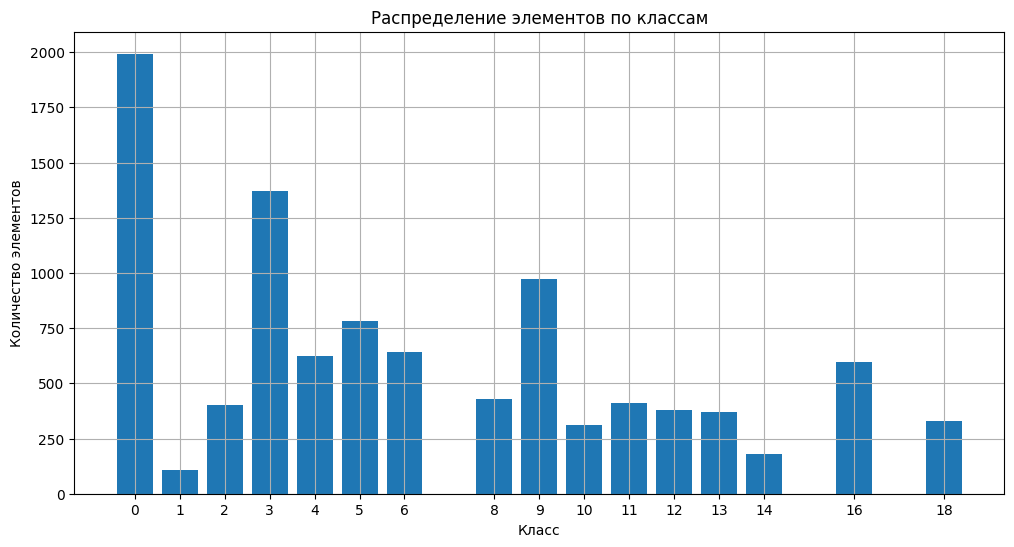

In [11]:
def count_classes(dataset):
    class_counts = defaultdict(int)
    
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] += 1
    
    print("Количество элементов по классам:")
    for class_id in sorted(class_counts.keys()):
        print(f"Класс {class_id}: {class_counts[class_id]} элементов")
    
    plt.figure(figsize=(12, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Класс')
    plt.ylabel('Количество элементов')
    plt.title('Распределение элементов по классам')
    plt.xticks(list(class_counts.keys()))
    plt.grid(True)
    plt.show()

class_counts = count_classes(train_set)
class_counts = count_classes(balanced_train_set)

In [9]:
BATCH_SIZE = 128

train_loader = DataLoader(balanced_train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [34]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (32, 64, 64)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (64, 32, 32)
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (128, 16, 16)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # (256, 16, 16)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (256, 8, 8)

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),  # (384, 8, 8)
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (384, 4, 4)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=3, stride=1, padding=1),  # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (512, 2, 2)

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),  # (1024, 2, 2)
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (1024, 1, 1)
        )



        self.skip1 = nn.Sequential(  # (32, 64, 64)
            nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1),  # (128, 64, 64)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 16, 16)
        )
        
        self.skip2 = nn.Sequential(  # (384, 4, 4)
            nn.Conv2d(384, 1024, kernel_size=3, stride=2, padding=1),  # (1024, 2, 2)
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (1024, 1, 1)
        )


        self.classifier = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 20)
        )

    def forward(self, x):
        x = self.block1(x)
        skip = self.skip1(x)
        out = self.block2(x)

        x = self.block3(skip + out)
        skip = self.skip2(x)
        out = self.block4(x)

        x = skip + out
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [35]:
model = Model2().to(device)
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5          [-1, 128, 32, 32]          36,992
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
         MaxPool2d-8          [-1, 128, 16, 16]               0
            Conv2d-9           [-1, 64, 64, 64]          18,496
      BatchNorm2d-10           [-1, 64, 64, 64]             128
             ReLU-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]          73,856
      BatchNorm2d-14          [-1, 128,

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out

class Model_Residual(nn.Module):
    def __init__(self, num_classes=20):
        super(Model_Residual, self).__init__()
        
        self.in_channels = 64
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, out_channels, blocks, stride):
        strides = [stride] + [1]*(blocks-1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [11]:
model = Model_Residual().to(device)
summary(model, input_size=(3, 64, 64), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
    ResidualBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [12]:
def show_losses(train, val, acc, f1):
    clear_output()
    plt.figure(figsize=(12,4))

    PAST_EPOCHS = len(train)
    
    plt.subplot(1, 3, 1)
    plt.title("Loss values")
    plt.plot(np.arange(PAST_EPOCHS), train, color="b", label=f'Train Loss = {train[-1]}')
    plt.plot(np.arange(PAST_EPOCHS), val, color="orange", label=f'Val Loss = {val[-1]}')
    plt.yscale('log')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("Accuracy")
    plt.plot(np.arange(PAST_EPOCHS), acc, color="orange", label=f'Acuracy = {acc[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("F1 score")
    plt.plot(np.arange(PAST_EPOCHS), f1, color="orange", label=f'F1 = {f1[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.tight_layout()
    plt.show()

In [13]:
def run_epoch(model, dataloader, loss_function, optimizer=None):
    
    model.train() if optimizer is not None else model.eval()

    total_loss = 0
    with torch.set_grad_enabled(optimizer is not None):
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_function(pred, y)

            total_loss += loss.item()

            if optimizer != None:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

    return total_loss / len(dataloader)

In [14]:
def predict(model, dataloader):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to('cpu')
            
            y_true += list(y)
            y_pred += list(torch.argmax(model(X), dim=1).cpu())
    return y_true, y_pred 

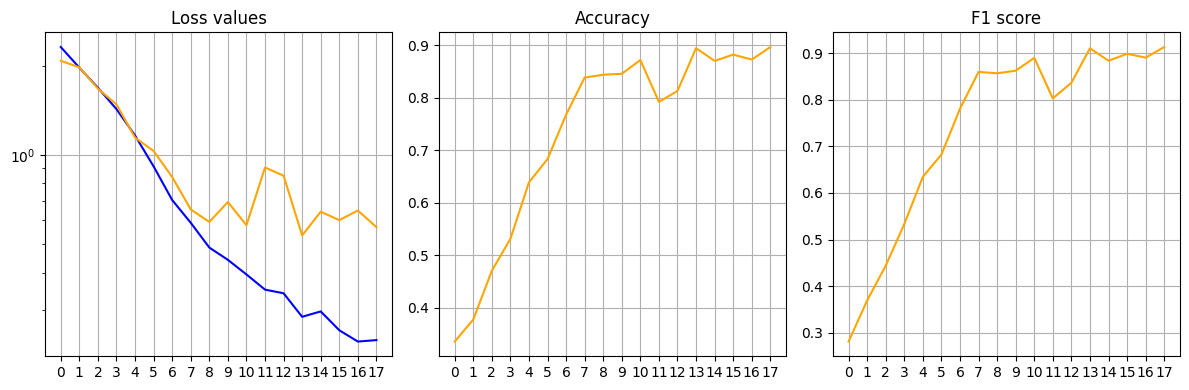

 88%|████████▊ | 110/125 [03:04<00:25,  1.68s/it]


KeyboardInterrupt: 

In [15]:
from sklearn.metrics import accuracy_score, f1_score

NUM_EPOCHS = 25

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), 
                           lr=0.001,
                           weight_decay=1e-5)


train_loss_hist = []
test_loss_hist = []
accuracy = []
f1 = []

for i in range(NUM_EPOCHS):

    train_loss = run_epoch(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)

    test_loss = run_epoch(model, valid_loader, loss_function)
    test_loss_hist.append(test_loss)

    y_true, y_pred = predict(model, valid_loader)
    accuracy.append(accuracy_score(y_true, y_pred))
    f1.append(f1_score(y_true, y_pred, average="macro"))

    if f1[-1] == max(f1):
        torch.save(model, 'model_with_residual.pth')
        torch.save(model.state_dict(), 'model_with_residual_weights.pth')

    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)


    

print(f"Min loss: {min(test_loss_hist):6>}")
print(f"Max Accuracy: {max(accuracy)}")
print(f"Max F1: {max(f1)}")

In [16]:
from sklearn.metrics import classification_report
model = torch.load('model_with_residual.pth', weights_only=False)
model.load_state_dict(torch.load('model_with_residual_weights.pth'))
model = model.to(device)

y_true, y_pred = predict(model, valid_loader)
print(classification_report(y_true, y_pred))

100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

              precision    recall  f1-score   support

           0       0.96      0.72      0.82       870
           1       0.92      0.98      0.95        45
           2       0.80      1.00      0.89       189
           3       0.89      0.79      0.84       594
           4       0.92      1.00      0.96       269
           5       0.89      0.98      0.93       347
           6       0.90      0.99      0.94       290
           8       0.85      0.99      0.92       176
           9       0.95      0.89      0.92       418
          10       0.88      0.97      0.92       127
          11       0.87      0.98      0.92       185
          12       0.78      0.99      0.88       161
          13       0.83      0.99      0.90       155
          14       0.87      0.99      0.92        72
          16       0.90      0.99      0.94       287
          18       0.94      0.96      0.95       143

    accuracy                           0.90      4328
   macro avg       0.88   

In [17]:
model = torch.load('model_with_residual.pth', weights_only=False)
model.load_state_dict(torch.load('model_with_residual_weights.pth'))
model = model.to(device)
model.eval()

# Подготовка для сохранения предсказаний
test_preds = []
test_ids = []

# Предсказание на тестовых данных
with torch.no_grad():
    for img_name in tqdm(test_set.image_files, desc="Processing test images"):
        img_path = os.path.join(test_set.image_dir, img_name)
        image = Image.open(img_path)
        image = test_set.transform(image).unsqueeze(0).to(device)  # Добавляем batch dimension
        
        output = model(image)
        _, pred = torch.max(output, 1)
        
        test_ids.append(img_name.split('.')[0])  # Извлекаем ID без расширения
        test_preds.append(pred.item())

# Сортируем по ID (если нужно)
test_ids, test_preds = zip(*sorted(zip(test_ids, test_preds), key=lambda x: int(x[0])))

# Сохраняем в CSV
with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'target_feature'])
    writer.writerows(zip(test_ids, test_preds))

print(f"Predictions saved to submission.csv, total {len(test_preds)} predictions")

Processing test images: 100%|██████████| 5301/5301 [01:48<00:00, 48.96it/s]

Predictions saved to submission.csv, total 5301 predictions
